In [17]:
### IMport libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
from torch.autograd import Variable
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import os

In [18]:
# Hyper-parameters
input_size = 784 # 28x28
#batch_size = 64

def test_train_data(train_bs,test_bs):
  # Define transformations for the data
    transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))])

    # Load the dataset
    train_dataset = MNIST(root='./data', train=True, transform=transform, download=True)
    train_loader = DataLoader(train_dataset, batch_size=train_bs, shuffle=True)

    test_dataset = MNIST(root='./data', train=False, transform=transform, download=True)
    test_loader = DataLoader(test_dataset, batch_size=test_bs, shuffle=False)

    return (train_loader, test_loader)

In [19]:
## Model 1
class Model1(nn.Module):
    def __init__(self):
        super(Model1, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 10)

    def forward(self, x):
        x = x.view(-1, input_size)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [20]:
def sensitive(model):
    fNormAll = 0
    counter = 0
    for p in model.parameters():
        grad = 0.0
        if p.grad is not None:
            grad = p.grad
            fNorm = torch.linalg.norm(grad).numpy()
            fNormAll += fNorm
            counter += 1
        sense = fNormAll / counter
    return sense

In [21]:
def train_model(model, optimizer, train_loader, criterion):
    model.train()

    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = Variable(data), Variable(target)
        optimizer.zero_grad()

        # Forward propagation
        output = model(data.view(-1, 784))
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

In [22]:
def loss_model(model, loader, criterion):
    correct = 0
    total = 0
    costTotal = 0
    costCounter = 0
    with torch.no_grad():
        for batch in loader:
            data, target = batch
            output = model(data.view(-1, 784))
            cost = criterion(output, target)
            costTotal += cost
            costCounter += 1
            for i, outputTensor in enumerate(output):
                if torch.argmax(outputTensor) == target[i]:
                    correct += 1
                total += 1
        tl = costTotal / costCounter
        acu =round(correct/total, 3)
    return tl,acu

In [34]:
n_epo = 2
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []
def train_test_model(model, optimizer):
    criterion = torch.nn.CrossEntropyLoss()
    for epoch in range(1, n_epo +1):
        train_model(model, optimizer, train_loader,criterion)

        train_loss, train_acc = loss_model(model, train_loader, criterion)
        test_loss, test_acc = loss_model(model, test_loader, criterion)

    train_losses.append(train_loss)
    test_losses.append(test_loss)

    train_accuracies.append(train_acc)
    test_accuracies.append(test_acc)

    print(f" Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}")


In [35]:
batch_list = [32, 64, 200, 500, 1024]
sensitivity_list= []
for batch in batch_list:
    torch.manual_seed(1)
    criterion = torch.nn.CrossEntropyLoss()
    train_loader, test_loader = test_train_data(batch, batch)
    model1 = Model1()
    optimizer = optim.Adam(model1.parameters(), lr = 1e-3, weight_decay = 1e-4)
    train_test_model(model1, optimizer)
    sensitivity_list.append(sensitive(model1))

 Train Loss: 0.2044, Test Loss: 0.2016
 Train Loss: 0.2222, Test Loss: 0.2242
 Train Loss: 0.2732, Test Loss: 0.2706
 Train Loss: 0.3427, Test Loss: 0.3372
 Train Loss: 0.3995, Test Loss: 0.3831


In [36]:
sensitivity_list

[1.1648028641939163,
 0.7300089380393425,
 0.35976286822309095,
 0.4137553259109457,
 0.27886319331203896]

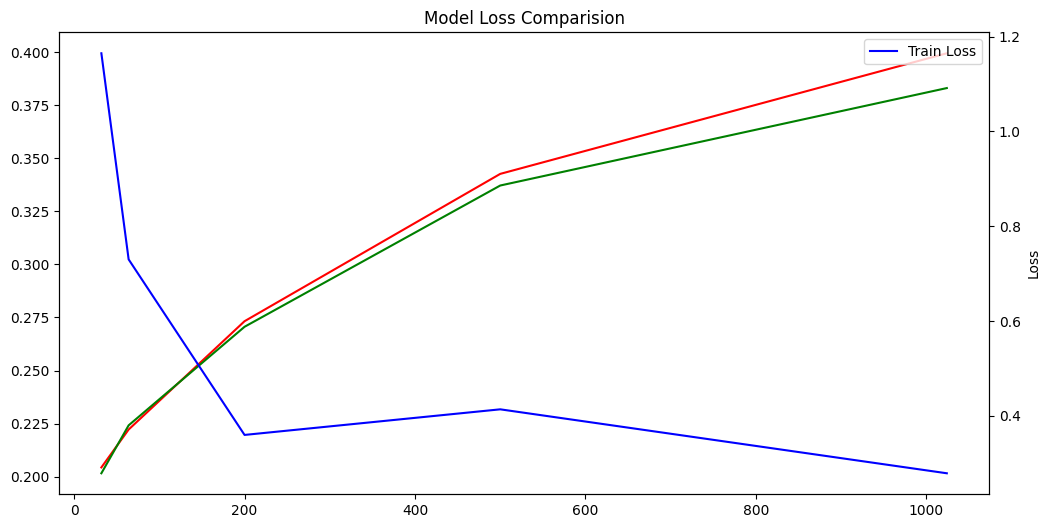

In [37]:
plt.figure(figsize=(12,6))
plt.plot(batch_list, train_losses, color = "r")
plt.plot(batch_list, test_losses, color = "g")
ax2 = plt.twinx()
plt.plot(batch_list, sensitivity_list, color = "b")
plt.title('Model Loss Comparision')
plt.legend(['Train Loss', 'Test Loss', 'Sensitivity'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

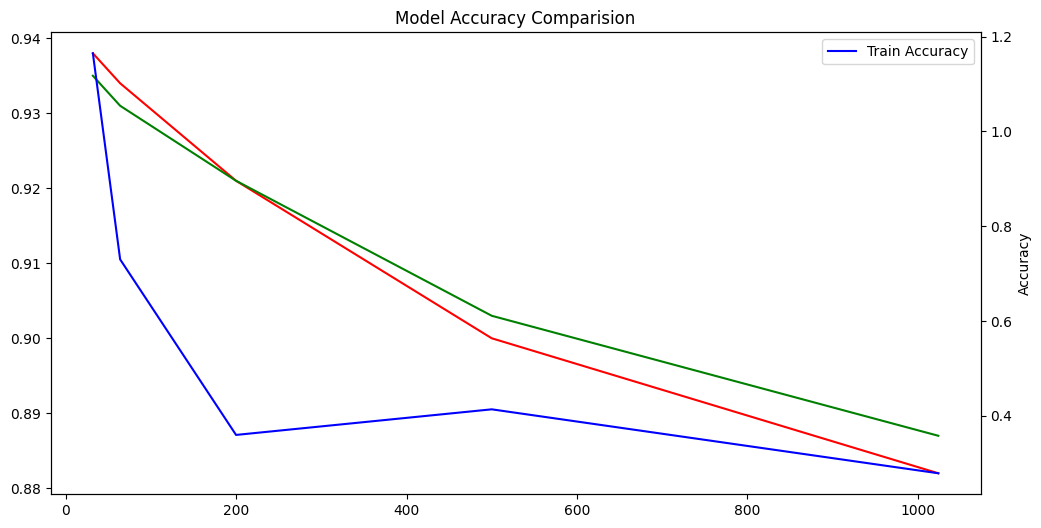

In [38]:
plt.figure(figsize=(12,6))
plt.plot(batch_list, train_accuracies, color = "r")
plt.plot(batch_list, test_accuracies, color = "g")
ax2 = plt.twinx()
plt.plot(batch_list, sensitivity_list, color = "b")
plt.title('Model Accuracy Comparision')
plt.legend(['Train Accuracy', 'Test Accuracy', 'Sensitivity'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()